## Import and install dependencies

In [1]:
## Download TorchVision repo
!rm -r vision
!git init
!pip install pycocotools --quiet
!git config --global --unset http.proxy 
!git config --global --unset https.proxy
!git clone https://github.com/pytorch/vision.git

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

## Basic libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
from sklearn.model_selection import train_test_split

## Torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## Image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


## Helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

rm: cannot remove 'vision': No such file or directory
Initialized empty Git repository in /kaggle/working/.git/
Cloning into 'vision'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 15443 (delta 63), reused 18 (delta 2), pack-reused 15345
Receiving objects: 100% (15443/15443), 16.09 MiB | 18.76 MiB/s, done.
Resolving deltas: 100% (10980/10980), done.


## Data access and cleaning

In [2]:
## Parent path to data
path = '/kaggle/input/data/'

boxCSV = 'BBox_List_2017.csv'
dataCSV = 'Data_Entry_2017.csv'

imageFolders = ['images_001', 'images_002', 'images_003',
       'images_004', 'images_005', 'images_006', 'images_007',
       'images_008', 'images_009', 'images_010', 'images_011',
       'images_012']

## First class is background
classes = [_, 'Infiltrate', 'Atelectasis', 'Pneumonia', 'Cardiomegaly','Effusion', 
           'Pneumothorax', 'Mass', 'Nodule']

## Image data
dataDF = pd.read_csv(path + dataCSV)
## Box data
boxDF = pd.read_csv(path + boxCSV)

dataGlob = glob('/kaggle/input/data/images*/images/*.png')

## Dictionary of image to path
imagePaths = {os.path.basename(x): x for x in dataGlob}
## Full image path data table
dataPath = dataDF['Image Index'].map(imagePaths.get)

## Full path to images with bounding boxes
boxPaths= boxDF['Image Index'].map(imagePaths.get)
## Isolate images with bounding boxes
boxImages = pd.merge(left = dataDF, right = boxDF, left_on = 'Image Index', right_on = 'Image Index', how = 'inner')
boxImages.dropna(axis = 1, inplace = True)
boxImages.drop(['y', 'Bbox [x', 'w', 'h]', 'Finding Label'], axis = 1, inplace = True)
boxDF.dropna(axis = 1, inplace = True)
## Rename columns
boxDF.columns = ['Image Index', 'Finding Label', 'X', 'Y', 'W', 'H']
boxImages.columns = ['Image Index', 'Finding Labels', 'Follow-Up Number', 'Patient ID', 'Patient Age', 'Patient Gender', 
                     'View', 'Position', 'Image Width', 'Image Height', 'Image Pixel Spacing X, Image Pixel Spacing Y']
## Append image path to DF
boxImages['Path'] = boxPaths

## Bounding box and label data groupings by image
xBox = boxDF.groupby('Image Index')['X'].apply(np.array).reset_index()['X'].values
yBox = boxDF.groupby('Image Index')['Y'].apply(np.array).reset_index()['Y'].values
wBox = boxDF.groupby('Image Index')['W'].apply(np.array).reset_index()['W'].values
hBox = boxDF.groupby('Image Index')['H'].apply(np.array).reset_index()['H'].values
## Group the finding labels together for the varying bounding boxes in each image
boxLabel = boxDF.groupby('Image Index')['Finding Label'].apply(np.array).reset_index()

## Data preprocessing

In [3]:
## Create a dictionary object for each image with its bounding box coords and labels
class NIHData(torch.utils.data.Dataset):
    def __init__(self, height, width, transforms = None):
        self.height = height
        self.width = width
        self.len = len(boxPaths.unique())
        self.transforms = transforms
    
    ## Overwrite and return the image dictionary
    def __getitem__(self, index):
        imagePath = boxPaths.iloc[index]

        # Read and resize the image
        origImage = cv2.imread(imagePath)
        image = cv2.cvtColor(origImage, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = cv2.resize(image, (self.width, self.height), cv2.INTER_AREA)
        image = image / 255.0
        
        ## Combine all boxes for an image together
        boxes = []
        labels = []
        
        ## Original image shape for normalizing
        Wimage = origImage.shape[1]
        Himage = origImage.shape[0]

        ## Create dictionary with image info and boxes
        for member in range(len(boxLabel['Finding Label'].iloc[index])):
            labels.append(classes.index(boxLabel['Finding Label'].iloc[index][member]))
                          
            xMin = xBox[index][member]
            xMax = xBox[index][member] + wBox[index][member]
            
            yMin = yBox[index][member]
            yMax = yBox[index][member] + hBox[index][member]
            
            xMinCorr = (xMin/Wimage) * self.width
            xMaxCorr = (xMax/Wimage) * self.width
            yMinCorr = (yMin/Himage) * self.height
            yMaxCorr = (yMax/Himage) * self.height
            
            boxes.append([xMinCorr, yMinCorr, xMaxCorr, yMaxCorr])
        
        ## Convert bounding boxes to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        ## Calculate area of boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        ## Suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        ## Create output dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        imageId = torch.tensor([index])
        target["image_id"] = imageId
        
        ## Apply data transformations to reduce overfitting
        if self.transforms:
            sample = self.transforms(image = image,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
               
        return image, target
    
    ## Overwrite function to return length of dataset
    def __len__(self):
        return self.len


## Check dataset length
dataset = NIHData(255, 255)
print("Length of dataset: ", len(dataset), "\n")

## Sample index to show image dictionary output
image, target = dataset[878]
print("Image shape: ", image.shape, "\n")
print("Image dictionary object: ", target)

Length of dataset:  880 

Image shape:  (255, 255, 3) 

Image dictionary object:  {'boxes': tensor([[152.5750, 114.5469, 208.3917, 147.6969],
        [152.3908, 109.6972, 191.7742, 147.3806]]), 'labels': tensor([1, 2]), 'area': tensor([1850.3225, 1484.0950]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([878])}


## Visualize an X-Ray image with bounding box

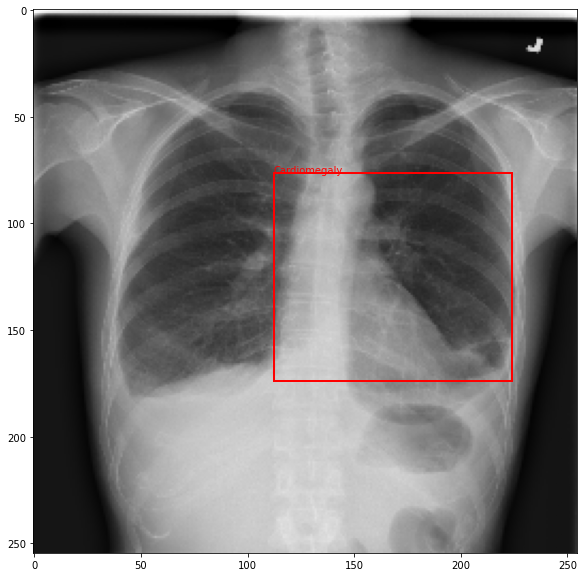

In [4]:
## Plot an image and overlay its bounding box on top of it
def plotImage(image, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    a.imshow(image)
    ## get the context for drawing boxes
    ax = plt.gca()
    ## Plot each box
    for i in range(len(target['boxes'])):
        box = target['boxes'][i]
        x, y, width, height  = box[0], box[1], box[2] - box[0], box[3] - box[1]
        ## Create rectangle patch for bounding box
        rect = patches.Rectangle((x, y), width, height, linewidth = 2, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)
        ## Draw text on top of box
        label = "%s" % (classes[target['labels'][i]])
        plt.text(x, y, label, color='red')
    ## show the plot
    plt.show()
    
## Plot a sample image
image, target = dataset[100]
plotImage(image, target)

## Import ResNet-50-FPN model

In [5]:
## Create the base model to be trained
def detectionModel(numClasses):
    ## Load a model pretrained resnet model to speed training time
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    ## Get number of input features for the classifier
    inFeatures = model.roi_heads.box_predictor.cls_score.in_features
    ## Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(inFeatures, numClasses) 

    return model

## Data transformations during training to reduce overfit
def createTransform(train):
    if train:
        return A.Compose([A.HorizontalFlip(0.5), ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Split training and test data

In [6]:
## Initialize train and test objects
dataTrain = NIHData(428, 428, createTransform(True))
dataTest = NIHData(428, 428, createTransform(False))

## Split the dataset into train and test sets
torch.manual_seed(1)
indices = torch.randperm(len(dataTrain)).tolist()
dataSplit = 0.2
testSize = int(len(dataTrain)*dataSplit)
dataTrain = torch.utils.data.Subset(dataTrain, indices[:-testSize])
dataTest = torch.utils.data.Subset(dataTest, indices[-testSize:])

## Define training and validation data loaders
dataTrainLoader = torch.utils.data.DataLoader(dataTrain, batch_size=8, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
dataTestLoader = torch.utils.data.DataLoader(dataTest, batch_size=8, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

NameError: name 'ChexNetData' is not defined

## Initialize model

In [ ]:
## Determine if we can use a GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Initialize model
numClasses = 9
model = detectionModel(numClasses)
model.double()
model.to(device)

## Construct an optimizer and learning rate
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lrScheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

## Train the model

In [ ]:
## Choose number of training epochs
numEpochs = 5

## Train one epoch at a time for numEpochs
for epoch in range(numEpochs):
    train_one_epoch(model, optimizer, dataTrainLoader, device, epoch, print_freq=10)
    ## Update the learning rate
    lrScheduler.step()
    ## Evaluate on the test dataset
    evaluate(model, dataTestLoader, device=device)

## Implement Non Max Suppresion

In [ ]:
## Non Max Suppression to determine best bounding box based on IOU threshold
def nms(prediction, thresh):
    ## Indeces of best bounding boxes
    bestBox = torchvision.ops.nms(prediction['boxes'], prediction['scores'], thresh)
    newPrediction = prediction
    newPrediction['boxes'] = newPrediction['boxes'][bestBox]
    newPrediction['scores'] = newPrediction['scores'][bestBox]
    newPrediction['labels'] = newPrediction['labels'][bestBox]
    
    return newPrediction

## Convert torch tensor to PIL image
def torchToPIL(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

## Test model on test dataset

In [ ]:
## Random image from test dataset
image, target = dataTest[57]
model.eval()
with torch.no_grad():
    prediction = model([image.to(device)])[0]
    
print('Predicted number of boxes: ', len(prediction['labels']))
print('True number of boxes: ', len(target['labels']))

## Visualize predictions and ground truth

In [ ]:
print('EXPECTED OUTPUT')
plotImage(torchToPIL(image), target)

In [ ]:
print('RAW MODEL OUTPUT')
plotImage(torchToPIL(image), prediction)

In [ ]:
nmsPrediction = nms(prediction, 0.25)
print("NMS APPLIED MODEL OUTPUT")
for x in range(len(nmsPrediction['scores'])):
    print("IOU:", nmsPrediction['scores'][x].item())
plotImage(torchToPIL(image), nmsPrediction)